In [87]:
# Definir as variáveis iniciais
num_nodes = 0
min_neighbors = 0
max_neighbors = 0
resources = {}
edges = []


# Abrir o arquivo de entrada
with open("entrada.txt", "r") as arquivo:
    # Ler cada linha do arquivo
    achou_resources = False
    achou_edges = False
    for linha in arquivo:
        # Remover espaços em branco no início e no final da linha
        linha = linha.strip()
        # Verificar se a linha não está vazia
        if linha:
           if('num_nodes:' in linha):
                num_nodes = int(linha.split(':')[1])
           if('min_neighbors:' in linha):
                min_neighbors = int(linha.split(':')[1])
           if('max_neighbors:' in linha):
                max_neighbors = int(linha.split(':')[1])
           if(achou_resources and 'edges' not in linha):
                chave = linha.split(":")[0]
                valor = linha.split(":")[1].replace(" ","").split(",")
                resources[chave]=valor
           if(achou_edges and 'resources' not in linha):
                values = linha.replace(" ","").split(",")
                edges.append(values)
           if('resources:' in linha):
                achou_resources = True
                achou_edges = False
           if('edges:' in linha):
               achou_resources = False
               achou_edges = True
           



            
  
          

# Imprimir as variáveis lidas do arquivo
print("num_nodes:", num_nodes)
print("min_neighbors:", min_neighbors)
print("max_neighbors:", max_neighbors)
print("resources:", resources)
print("edges:", edges)


num_nodes: 3
min_neighbors: 1
max_neighbors: 3
resources: {'n1': ['r1', 'r2', 'r3'], 'n2': ['r4', 'r5'], 'n3': ['r6', 'r7']}
edges: [['n1', 'n2'], ['n1', 'n3'], ['n2', 'n3']]


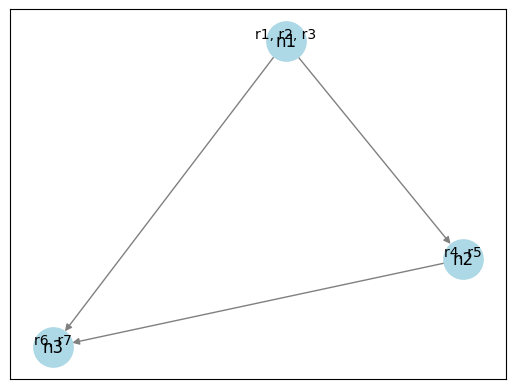

In [93]:

# Criando um novo grafo direcionado
grafo = nx.DiGraph()


# Adicionando os nós ao grafo
for i in range(1, num_nodes + 1):
    node_name = 'n{}'.format(i)
    grafo.add_node(node_name,recursos=resources[node_name])

# Adicionando as arestas ao grafo
for edge in edges:
    source = edge[0]
    target = edge[1]
    grafo.add_edge(source, target)



pos = nx.spring_layout(grafo, seed=42)
node_labels = {node: f"{', '.join(grafo.nodes[node]['recursos'])}" for node in grafo.nodes()}
nx.draw_networkx(grafo, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=12, edge_color='gray')
nx.draw_networkx_labels(grafo, pos, labels=node_labels, font_size=10, verticalalignment="bottom")

# Exibindo o gráfico
plt.show()

